In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-of-financial-news-headlines/sample_submission.csv
/kaggle/input/sentiment-analysis-of-financial-news-headlines/train.csv
/kaggle/input/sentiment-analysis-of-financial-news-headlines/test.csv
/kaggle/input/test-dig-dep-hack-updated/test.csv


In [3]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-of-financial-news-headlines/train.csv', sep=';')
df.head(5)

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,10897,Корея может стать следующей Японией для инвест...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(7161, 9)

In [6]:
sample_df = pd.read_csv('/kaggle/input/sentiment-analysis-of-financial-news-headlines/sample_submission.csv')
sample_df.head(5)

,id,sber_n,sber_0,sber_p,vtb_n,vtb_0,vtb_p,gazprom_n,gazprom_0,gazprom_p,...,alfabank_p,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,company_n,company_0,company_p
0,2807,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5231,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9155,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,2525,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,7702,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
bank_columns = ['sber', 'vtb', 'gazprom', 'alfabank', 'raiffeisen', 'rshb']

n_banks = 6

In [8]:
df['is_bank'] = np.zeros_like(df['text'])

df['is_company'] = np.zeros_like(df['text'])

In [9]:
for index, row in df[bank_columns].iterrows():
    if row.isna().sum() == n_banks:
        df.loc[index, "is_bank"] = 0.0
    else:
        df.loc[index, "is_bank"] = 1.0

In [10]:
for index, row in df[['company']].iterrows():
    if row.isna().sum() == 1.0:
        df.loc[index, "is_company"] = 0.0
    else:
        df.loc[index, "is_company"] = 1.0

In [11]:
df.sample(10)

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company
3647,17453,Кредитный отдел газпромбанка москва,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0
2064,11301,Топ-10 дивидендных российских акций,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1678,4101,Кредитный отдел сбербанк ленина 70 кемерово,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
5011,4549,как рефинансировать кредит в сбербанке,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
5975,8105,заполнить платежку на карта сбербанк,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
6635,19326,Процентная ставка по кредитам сбер банка,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
6686,16687,Банк уралсиб кредит на строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4513,1434,Дурацкий сбербанк!где мой перевод,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
5062,2737,Кредит райффайзен банк аваль,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,0.0
3057,1960,ВТБ размещает однодневные облигации на 50 млрд...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [12]:
bank_pattern = r'банк|bank'
sber_pattern = r'sber|сбер|sberbank|сбербанк'
vtb_pattern = r'vtb|втб|внешторгбанк|бтв'
gazprom_pattern = r'gazprombank|гпб|газпромбанк'
alfabank_pattern = r'alfa|alfabank|alfa-bank|альфа|альфабанк|альфа-банк'
raiffeisen_pattern = r'raiffeisen|raif|райффайзен|рфб|райф|райфф|райфазен|раиффайзен|раиф'
rshb_pattern = r'rshb|россельхоз|россельхозбанк|рсх|рсхб'
uralsib_pattern = r'уралсиб|uralsib'
company_pattern = r'лукойл|россети|veon|северстал|twitter|газпром|hershey|booking|куйбышевазот|\
pepsi|heinz|pfizer|спб биржа|siemens|polymetal|энел|uber|halliburton\
|moderna|accenture|cisco|wintershall|интеррос|johnson|тгк-2|тиньк|маск|роснефт|аэрофлот|новатэк|apple|samsung|акрон|vk|яндекс|лента|мтс|магнит|совкомфлот|нлмк|алрос|shell|ммк| \
nasa|mastercard|ростелеком|jpmorgan|hsbc|netflix|qiwi|киви|moody|сдэк|qatarenergy|ercsson|nokia|google|xiaomi|vmware|avito'

In [13]:
df['is_sber'] = df['text'].str.contains(sber_pattern, case=False) * df['text'].str.contains(bank_pattern, case=False)
df

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True
1,10897,Корея может стать следующей Японией для инвест...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,1.0,0.0,False
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,False
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7156,3721,У твиттера Сбербанка 42 тыс.читателейВТБ13 тыс.,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True
7157,18578,заместителя руководителя пошёл на повышение кл...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True
7158,91,Оформить кредитную карту альфа банк,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,False
7159,14728,Кредиты малого бизнеса втб 24 г иркутск,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False


In [14]:
df['is_vtb'] = df['text'].str.contains(vtb_pattern, case=False)

df['is_gazprom'] = df['text'].str.contains(gazprom_pattern, case=False)

df['is_alfabank'] = df['text'].str.contains(alfabank_pattern, case=False)

df['is_raiffeisen'] = df['text'].str.contains(raiffeisen_pattern, case=False)

df['is_rshb'] = df['text'].str.contains(rshb_pattern, case=False)

In [15]:
df['is_company_pattern'] = df['text'].str.contains(company_pattern, case=False)

In [16]:
df['sent'] = np.zeros_like(df['text']) * np.nan

In [17]:
sent_columns = ['sber', 'vtb', 'gazprom', 'alfabank', 'raiffeisen', 'rshb', 'company']

In [18]:
for index, row in df[sent_columns].iterrows():
    df.loc[index, 'sent'] = np.max(row)

In [19]:
df.head(5)

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,sent
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,True,False,False,False,False,False,1.0
1,10897,Корея может стать следующей Японией для инвест...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False,False,False,False,False,False,False,NaN
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,-1.0
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,False,False,False,False,False,False,True,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0


In [88]:
df_w_sent = df.query('not (is_bank == 0.0 and is_company == 0.0)').copy()
df_w_sent

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,sent
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,True,False,False,False,False,False,1.0
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,-1.0
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,False,False,False,False,False,False,True,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0
5,6466,Оформить кредит россельхозбанк,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,False,False,False,False,False,True,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7156,3721,У твиттера Сбербанка 42 тыс.читателейВТБ13 тыс.,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,True,False,False,False,False,False,0.0
7157,18578,заместителя руководителя пошёл на повышение кл...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,0.0
7158,91,Оформить кредитную карту альфа банк,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,False,False,False,True,False,False,False,0.0
7159,14728,Кредиты малого бизнеса втб 24 г иркутск,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0


Undersampling

In [89]:
count_class_0, count_class_n, count_class_p = df_w_sent.sent.value_counts()
df_w_sent.sent.value_counts()

sent
 0.0    4651
-1.0    1119
 1.0    1102
Name: count, dtype: int64

In [90]:
# Divide by class
df_class_0 = df_w_sent[df_w_sent.sent == 0.0].copy()
df_class_n = df_w_sent[df_w_sent.sent == -1.0].copy()
df_class_p = df_w_sent[df_w_sent.sent == 1.0].copy()

In [91]:
df_class_n.shape

(1119, 19)

In [92]:
df_class_0_under = df_class_0.sample(count_class_p).copy()
df_class_n_under = df_class_n.sample(count_class_p).copy()

In [93]:
df_w_sent_under = pd.concat([df_class_0_under, df_class_n_under, df_class_p], axis=0)
df_w_sent_under

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,sent
2962,7903,Выдаёт ли сбербанк кредиты,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,0.0
437,2338,По делу: Украина в 2014 году выплатит $750 млн...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,0.0
325,7469,"Россети Центр и Приволжье может выплатить 0,00...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,False,False,False,False,False,False,True,0.0
3396,4285,Кредит в россельхозбанк в г орске,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,False,False,False,False,False,True,False,0.0
4224,10791,"Ставка 2-го купона по облигациям ""Газпромбанка...",NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,18554,"Аналитики ждут щедрых дивидендов от Сбербанка,...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,1.0
7131,18660,Газпромбанк в 2022г увеличил розничный кредитн...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,1.0
7139,153,Немецкая VNG согласилась платить за газ через ...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,1.0
7140,5820,Через Сбербанк Онл@йн теперь возможно оплачива...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,1.0


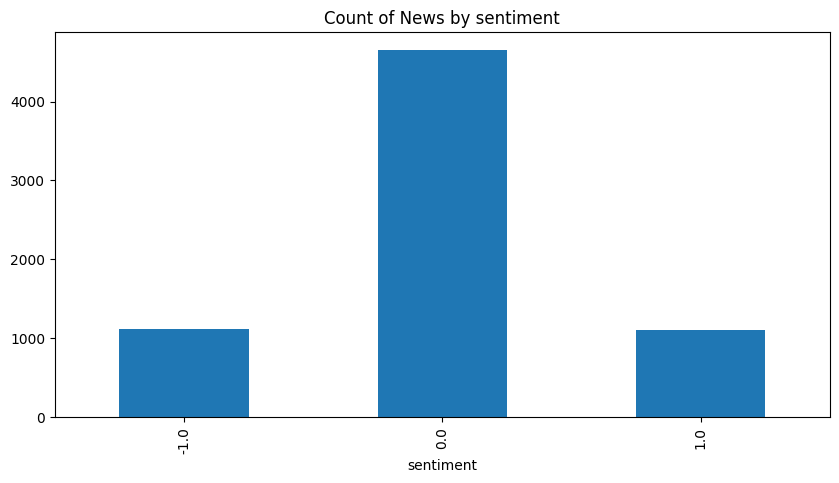

In [94]:
ax = df_w_sent['sent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of News by sentiment',
          figsize=(10, 5))
ax.set_xlabel('sentiment')
plt.show()

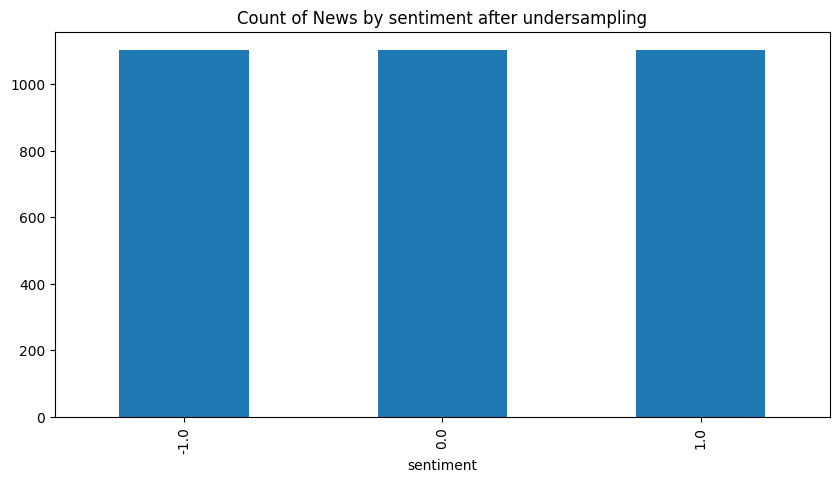

In [95]:
ax = df_w_sent_under['sent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of News by sentiment after undersampling',
          figsize=(10, 5))
ax.set_xlabel('sentiment')
plt.show()

preprocessing

In [96]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
stopWords = set(stopwords.words('russian'))

In [98]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [100]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('russian'))
nltk.download('wordnet')
wnl = nltk.SnowballStemmer('russian')
# wnl = nltk.SnowballStemmer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
import re

In [86]:
def clean_text(text):
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = re.sub(r'<.*?>', '', text)    # Remove HTML tags
#     text = re.sub('[^A-Za-z]+','', text) # Remove non-alpha characters
    text = re.sub(' +', ' ', text)       # Remove extra-spaces
    text = text.lower()                  # Convert to lowercase
    return text

In [104]:
s = 'игра'
s.isalpha()

True

In [128]:
df_w_sent['text'] = df_w_sent['text'].apply(clean_text)
df_w_sent

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,sent
0,8292,novosti сбербанк и втб пообещали выполнить обя...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,True,False,False,False,False,False,1.0
2,3964,новые санкции затрагивают и газпромбанк sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,-1.0
3,11829,veon заявила об обесценивании бизнеса в россии...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,False,False,False,False,False,False,True,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0
5,6466,оформить кредит россельхозбанк,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,False,False,False,False,False,True,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7156,3721,у твиттера сбербанка тысчитателейвтб тыс,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,True,False,False,False,False,False,0.0
7157,18578,заместителя руководителя пошёл на повышение кл...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,0.0
7158,91,оформить кредитную карту альфа банк,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,False,False,False,True,False,False,False,0.0
7159,14728,кредиты малого бизнеса втб г иркутск,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0


In [108]:
df_w_sent_under['text'] = df_w_sent_under['text'].apply(clean_text)
df_w_sent_under

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,sent
2962,7903,выдаёт ли сбербанк кредиты,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,0.0
437,2338,по делу украина в году выплатит млн по обесцен...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,0.0
325,7469,россети центр и приволжье может выплатить руб ...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,False,False,False,False,False,False,True,0.0
3396,4285,кредит в россельхозбанк в г орске,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,False,False,False,False,False,True,False,0.0
4224,10791,ставка го купона по облигациям газпромбанка се...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,18554,аналитики ждут щедрых дивидендов от сбербанка ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,1.0
7131,18660,газпромбанк в г увеличил розничный кредитный п...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,1.0
7139,153,немецкая vng согласилась платить за газ через ...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,True,1.0
7140,5820,через сбербанк онлйн теперь возможно оплачиват...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,1.0


In [129]:
def preproc_nltk(text):
    return ' '.join([wnl.stem(word) for word in word_tokenize(text.lower()) if word not in stopWords and word.isalpha()])

In [130]:
vectorizer = TfidfVectorizer(preprocessor=preproc_nltk)

In [132]:
vectors = vectorizer.fit_transform(df_w_sent['text'])

In [133]:
vectorizer.get_feature_names_out().shape

(6997,)

In [ ]:
vectorizer.vocabulary_

In [153]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': <function __main__.preproc_nltk(text)>,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import SGDClassifier 

In [135]:
X = np.asarray(vectors.todense())

In [147]:
X.shape

(6872, 6997)

(array([ 2064.,  5320., 12798., 13662.,  6505.,  2726.,  1498.,   813.,
          458.,   142.]),
 array([0.03243609, 0.12919248, 0.22594887, 0.32270526, 0.41946165,
        0.51621805, 0.61297444, 0.70973083, 0.80648722, 0.90324361,
        1.        ]),
 <BarContainer object of 10 artists>)

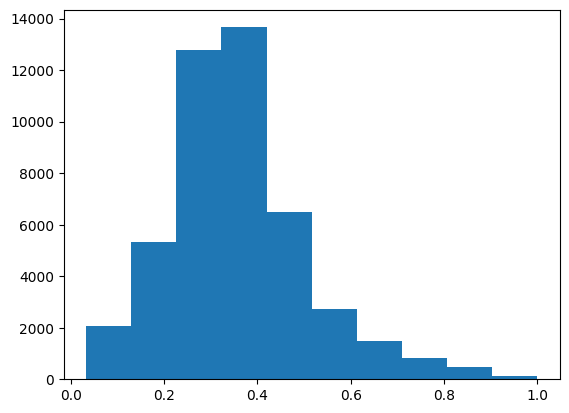

In [146]:
plt.hist(X[X.nonzero()])

In [117]:
sent_mapping = {-1: 'n',
               0: '0',
               1: 'p'}

In [136]:
y = df_w_sent['sent'].map(sent_mapping).copy()
y

0       p
2       n
3       n
4       0
5       0
       ..
7156    0
7157    0
7158    0
7159    0
7160    0
Name: sent, Length: 6872, dtype: object

In [137]:
val_size = 0.3
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=val_size, random_state=15)

In [138]:
X_train.shape

(4810, 6997)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

Boosting classifiers

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
catboost_clf = CatBoostClassifier(verbose=0)

In [ ]:
catboost_clf.fit(X_train, y_train)

In [ ]:
accuracy_score(y_val, catboost_clf.predict(X_val))

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier()

In [ ]:
xgb_clf.fit(X_train, y_train_xgb)

In [ ]:
accuracy_score(y_val, pd.Series((xgb_clf.predict(X_val) - 1)).map(sent_mapping))

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm_clf = LGBMClassifier()

In [ ]:
lgbm_clf.fit(X_train, y_train)

In [ ]:
accuracy_score(y_val, lgbm_clf.predict(X_val))

stacking classifiers

In [ ]:
weak_learners = [('sgd', SGDClassifier(max_iter=1000, warm_start=True, tol=1e-8)),
                         ('cb', CatBoostClassifier(verbose=0)),
                         ('lgbm', LGBMClassifier()),
                         ('xgb', XGBClassifier())]

In [ ]:
final_learner = CatBoostClassifier(verbose=0)

In [ ]:
X_train_stack, X_val_stack, y_train_stack, y_val_stack= train_test_split(X_train, y_train_xgb, stratify=y_train_xgb, test_size=val_size, random_state=42)

In [ ]:
train_meta_model = None
test_meta_model = None

In [ ]:
train_meta_features = []
test_meta_features = []

In [ ]:
for idx, (clf_id, clf) in enumerate(weak_learners):
    # Predictions for each classifier based on k-fold
    clf.fit(X_train_stack, y_train_stack)
    val_predictions = clf.predict(X_val_stack)
    test_predictions = clf.predict(X_val)

    # Stack predictions which will form 
    # the input data for the data model
    train_meta_features.append(val_predictions)

    test_meta_features.append(test_predictions)

In [ ]:
train_meta_features

In [ ]:
train_meta_features[1] = np.array(train_meta_features[1]).T.reshape(-1)

In [ ]:
train_meta_features[0].shape

In [ ]:
train_meta_features[1].shape

In [ ]:
train_meta_features = np.array(train_meta_features).T
train_meta_features

In [ ]:
train_meta_features

In [ ]:
test_meta_features[1] = np.array(test_meta_features[1]).T.reshape(-1)

In [ ]:
test_meta_features = np.array(test_meta_features).T
test_meta_features

In [ ]:
final_learner.fit(train_meta_features, y_val_stack)

In [ ]:
test_meta_pred = pd.Series(final_learner.predict(test_meta_features).reshape(-1) - 1).map(sent_mapping)
test_meta_pred

In [ ]:
y_val

In [ ]:
accuracy_score(y_val, test_meta_pred)

Logistic regression

In [139]:
from sklearn.linear_model import LogisticRegression

In [173]:
log_reg_clf = LogisticRegression(C=5, max_iter=1000,solver='saga')

In [174]:
log_reg_clf.fit(X_train, y_train)

LogisticRegression(C=5, max_iter=1000, solver='saga')

In [175]:
from sklearn.metrics import f1_score

In [176]:
f1_score(y_val, log_reg_clf.predict(X_val), average="macro")

0.7529417447823855

In [168]:
accuracy_score(y_val, log_reg_clf.predict(X_val))

0.8346265761396702

In [145]:
accuracy_score(y_train, log_reg_clf.predict(X_train))

0.9237006237006237

SGD classifier

In [72]:
clf = SGDClassifier(max_iter=2000, warm_start=True)

In [73]:
clf.fit(X_train, y_train)

SGDClassifier(max_iter=2000, warm_start=True)

In [74]:
val_pred = clf.predict(X_val)

In [75]:
f1_score(y_val, val_pred, average="micro")

0.7691532258064516

In [76]:
f1_score(y_val, val_pred, average="macro")

0.768565274748337

In [ ]:
accuracy_score(y_val, val_pred)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
multilabel_confusion_matrix(y_val, val_pred, labels=["n", "0", "p"])

In [ ]:
accuracy_score(y_train, clf.predict(X_train))

SVC

In [77]:
svc = svm.SVC(kernel='rbf', C=15, probability=True).fit(X_train, y_train) 
prediction = svc.predict(X_val) 

In [78]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [79]:
f1_score(y_val, prediction, average="macro")

0.7885330291679221

In [80]:
f1_score(y_train, svc.predict(X_train), average="macro")

0.9987120890021662

In [177]:
df_test = pd.read_csv('/kaggle/input/test-dig-dep-hack-updated/test.csv', sep=';')
df_test.head()

,id,text
0,2807,Банк втб киров взять кредитную карту через онлайн
1,5231,должники по кредитам сбербанка
2,9155,RT @RT_russian: ЕС ограничил доступ к рынкам к...
3,2525,Zaletchikya В Сочи банкоматы Сбербанка будут н...
4,7702,RT @etuduvudp: Сбербанк прислал СМС о возможно...


In [178]:
df_test['text'] = df_test['text'].apply(clean_text)
df_test

,id,text
0,2807,банк втб киров взять кредитную карту через онлайн
1,5231,должники по кредитам сбербанка
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...
4,7702,rt etuduvudp сбербанк прислал смс о возможност...
...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...
4784,17995,rt morketolog цифра дня средняя зарплата в газ...
4785,7571,аэрофлот получит отечественных самолета в годах
4786,6279,лондон включил в санкционные списки по рф боле...


In [179]:
np.array(df_test.sample(15))

array([[2045, 'акции втб близки к справедливой оценке после роста'],
       [5312, 'заявление анкета кредита сбербанк россии'],
       [10817,
        'госдума приняла во ii чтении законопроект о долгосрочных сбережениях гражд '],
       [3634,
        'на стабильную работу россельхозбанка не повлияют санкции ес и сша'],
       [8358, 'rt auffpsrsdzbb сбербанк на телефон'],
       [18555, 'проценты на кредит сбербанк'],
       [8307,
        'бумаги аэрофлота корректируются после новости о сокращении господдержки для авиакомпаний'],
       [15015, 'говоряющий банкомат сбербанка via oksana_kocherga'],
       [10511,
        'аэрофлот в лидерах роста на новостях о возможной господдержке отрасли'],
       [8721,
        'сбер заключил первую сделку передачи цфа на золото третьим лицам'],
       [18260,
        'хочу взять в кредит денги в альфа банке с кредитной карты виза'],
       [6646,
        'сша ограничили использование вакцины johnson johnson от covid'],
       [7880,
        'нов

In [180]:
df_test.shape

(4788, 2)

In [181]:
test_vectors = vectorizer.transform(df_test['text'])

In [184]:
test_vectors.shape

(4788, 6997)

(array([1504., 3919., 7877., 8224., 4318., 1908., 1030.,  581.,  316.,
         122.]),
 array([0.052032 , 0.1468288, 0.2416256, 0.3364224, 0.4312192, 0.526016 ,
        0.6208128, 0.7156096, 0.8104064, 0.9052032, 1.       ]),
 <BarContainer object of 10 artists>)

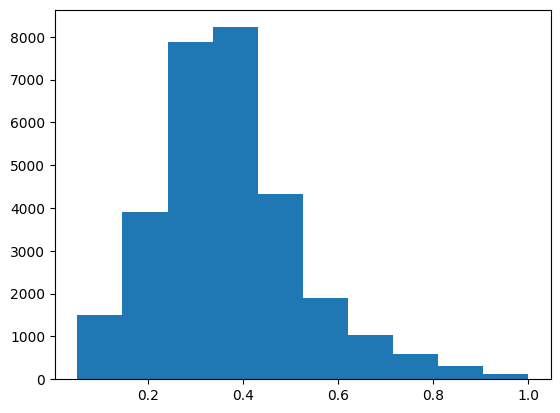

In [188]:
plt.hist(test_vectors.toarray()[test_vectors.toarray().nonzero()].flatten())

In [189]:
test_pred = log_reg_clf.predict(test_vectors.toarray())

In [190]:
test_pred

array(['0', '0', 'n', ..., 'p', 'n', 'p'], dtype=object)

In [191]:
df_test['clf_sent'] = test_pred

In [192]:
df_test.sample(10)

,id,text,clf_sent
1041,2440,сбербанк уверенно идет на трлн руб прибыли по ...,p
2849,16235,альфа банк уфа оформить кредит онлайн,0
4706,14505,rt highway_to_heli вкладчикам нмб отдадут день...,0
1520,434,pavlova_ сбербанк в ночь на августа приостанов...,n
3710,12024,rt yonchik никогда не переводите деньги из qiw...,n
3081,17024,sberbank всё отлично только вашим банком и пол...,p
441,7521,ес ограничил доступ к рынкам капитала сбербанк...,n
0,2807,банк втб киров взять кредитную карту через онлайн,0
1563,7002,юго западный сбербанк кредит,0
1026,9730,как оформить кредит в сбер банк россиии,0


In [193]:
sent_inv_mapping = {'n': -1,
               '0': 0,
               'p': 1}

In [194]:
df_test['clf_sent'] = df_test.clf_sent.map(sent_inv_mapping)
df_test

,id,text,clf_sent
0,2807,банк втб киров взять кредитную карту через онлайн,0
1,5231,должники по кредитам сбербанка,0
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0
...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0
4785,7571,аэрофлот получит отечественных самолета в годах,1
4786,6279,лондон включил в санкционные списки по рф боле...,-1


In [195]:
df_test.sample(15)

,id,text,clf_sent
159,14973,можно ли взять кредит не в своем городе сбербанк,0
837,13213,rt surkovrussia реструктуризация почты россии ...,0
928,6697,кредит втб калькулятор,0
286,440,новости северозападный сбербанк увеличил ипоте...,0
2864,9147,кредит райфайзенг банк г курск,0
1944,19824,можно ли взять кредит в сбербанке без справок,0
2613,11112,сбербанк увидел в санкциях ес угрозу для глоба...,-1
3195,18712,справка альфа банка для потребительского кредита,0
2872,13576,rt codkite хм только вчера сказал в банке свой...,-1
4572,17541,в новогодние праздники сбербанк будет работать...,0


In [196]:
df_test['is_sber'] = df_test['text'].str.contains(sber_pattern, case=False)
df_test

,id,text,clf_sent,is_sber
0,2807,банк втб киров взять кредитную карту через онлайн,0,False
1,5231,должники по кредитам сбербанка,0,True
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True
...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False
4785,7571,аэрофлот получит отечественных самолета в годах,1,False
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False


In [197]:
df_test['is_vtb'] = df_test['text'].str.contains(vtb_pattern, case=False)
df_test

,id,text,clf_sent,is_sber,is_vtb
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True
1,5231,должники по кредитам сбербанка,0,True,False
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True,True
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True,False
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True,False
...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False,False
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False,False
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False,False


In [198]:
df_test['is_gazprom'] = df_test['text'].str.contains(gazprom_pattern, case=False)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False
1,5231,должники по кредитам сбербанка,0,True,False,False
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True,True,True
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True,False,False
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True,False,False
...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False,False,False
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False,False,True
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False,False,False


In [199]:
df_test['is_alfabank'] = df_test['text'].str.contains(alfabank_pattern, case=False)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False,False
1,5231,должники по кредитам сбербанка,0,True,False,False,False
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True,True,True,False
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True,False,False,False
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True,False,False,False
...,...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False,False,False,False
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False,False,True,False
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False,False
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False,False,False,False


In [200]:
df_test['is_raiffeisen'] = df_test['text'].str.contains(raiffeisen_pattern, case=False)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True,True,True,False,False
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True,False,False,False,False
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False,False,False,False,False
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False,False,True,False,False
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False,False,False
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False,False,False,False,False


In [201]:
df_test['is_rshb'] = df_test['text'].str.contains(rshb_pattern, case=False)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False,False
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False,False
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True,True,True,False,False,True
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True,False,False,False,False,False
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False,False,False,False,False,False
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False,False,True,False,False,False
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False,False,False,False
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False,False,False,False,False,False


In [202]:
df_test['is_company_pattern'] = df_test['text'].str.contains(company_pattern, case=False)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False,False,False
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False,False,False
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True,True,True,False,False,True,True
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True,False,False,False,False,False,False
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False,False,False,False,False,False,True
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False,False,True,False,False,False,True
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False,False,False,False,True
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False,False,False,False,False,False,False


In [203]:
df_test['is_uralsib'] = df_test['text'].str.contains(uralsib_pattern, case=False)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,is_uralsib
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False,False,False,False
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False,False,False,False
2,9155,rt rt_russian ес ограничил доступ к рынкам кап...,-1,True,True,True,False,False,True,True,False
3,2525,zaletchikya в сочи банкоматы сбербанка будут н...,0,True,False,False,False,False,False,False,False
4,7702,rt etuduvudp сбербанк прислал смс о возможност...,0,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в ...,1,False,False,False,False,False,False,True,False
4784,17995,rt morketolog цифра дня средняя зарплата в газ...,0,False,False,True,False,False,False,True,False
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False,False,False,False,True,False
4786,6279,лондон включил в санкционные списки по рф боле...,-1,False,False,False,False,False,False,False,False


In [204]:
is_bank_columns = [
#     'is_bank', 
                   'is_sber', 'is_vtb', 'is_gazprom', 'is_alfabank', 'is_raiffeisen', 'is_rshb']

In [205]:
df_test['is_company'] = np.nan * np.ones_like(df_test['text'])

In [206]:
pd.set_option('display.max_colwidth', 250)

In [207]:
df_test.sample(15)

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,is_uralsib,is_company
216,1797,заявление на закрытие счета карты в сбербанке,0,True,False,False,False,False,False,False,False,NaN
2755,13617,российский рынок итоги торгов очередной обвал рынка акций в лидерах сбербанк и втб,1,True,True,False,False,False,False,False,False,NaN
4263,10209,rt victorcano сбербанк бизнес онлайн вход в систему ic,0,True,False,False,False,False,False,False,False,NaN
2387,6845,rt banki_ru европейские санкции третьего уровня затронут сбербанк,-1,True,False,False,False,False,False,False,False,NaN
1096,1040,втб разместил выпуска однодневных бондов серии кс на млрд рубле,0,False,True,False,False,False,False,False,False,NaN
1817,9397,банк втб ипотечный кредит,0,False,True,False,False,False,False,False,False,NaN
1603,1720,северсталь остается бенефициаром высоких цен на сталь и ослабления курса рубля,0,False,False,False,False,False,False,True,False,NaN
3056,4093,netflix потерял вдвое меньше платных подписчиков чем прогнозировал,-1,False,False,False,False,False,False,True,False,NaN
4639,3896,убыток до налогообложения во втором квартале года в миллионов долларов сша был напрямую связан с введенными санкциями и приостановкой нашей деятельности в рф сообщила компания,-1,False,False,False,False,False,False,False,False,NaN
706,2546,как закрыть кредит в сбербанке,0,True,False,False,False,False,False,False,False,NaN


In [208]:
for index, row in df_test[is_bank_columns].iterrows():
#     if np.sum(row) == 0 and df_test.loc[index, 'is_company_pattern'] == True:
    if (np.sum(row) == 0 and df_test.loc[index, 'is_company_pattern'] == True):
        df_test.loc[index, 'is_company'] = True
    else:
        df_test.loc[index, 'is_company'] = False

In [209]:
sentiments = ['n', '0', 'p']

In [210]:
for bank in bank_columns:
    for sentiment in sentiments:
        df_test[f'{bank}_{sentiment}'] = np.ones_like(df_test['text'])

In [211]:
df_test['clf_sent_label'] = df_test['clf_sent'].map(sent_mapping)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,...,alfabank_n,alfabank_0,alfabank_p,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,clf_sent_label
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,0
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,0
2,9155,rt rt_russian ес ограничил доступ к рынкам капитала для сбербанка втб газпромбанка внешэкономбанка россельхозбанка,-1,True,True,True,False,False,True,True,...,1,1,1,1,1,1,1,1,1,n
3,2525,zaletchikya в сочи банкоматы сбербанка будут на китайском и французском языках,0,True,False,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,0
4,7702,rt etuduvudp сбербанк прислал смс о возможности пополнения счета на мтс без комисси путём отправления смс на определённый номер с указ,0,True,False,False,False,False,False,True,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в иран,1,False,False,False,False,False,False,True,...,1,1,1,1,1,1,1,1,1,p
4784,17995,rt morketolog цифра дня средняя зарплата в газпромбанке превышает тысяч рублей,0,False,False,True,False,False,False,True,...,1,1,1,1,1,1,1,1,1,0
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False,False,False,False,True,...,1,1,1,1,1,1,1,1,1,p
4786,6279,лондон включил в санкционные списки по рф более человек и предприятий мид б,-1,False,False,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,n


In [212]:
for index, row in df_test.iterrows():
    for bank in bank_columns:
        for sentiment in sentiments:
            if ((row[f'is_{bank}'] == True) and (row['clf_sent_label'] == sentiment)):
                df_test.loc[index, f'{bank}_{sentiment}'] = 1
            else:
                df_test.loc[index, f'{bank}_{sentiment}'] = 0
    for sentiment in sentiments:
        if ((row[f'is_company'] == True) and (row['clf_sent_label'] == sentiment)):
            df_test.loc[index, f'company_{sentiment}'] = 1
        else:
            df_test.loc[index, f'company_{sentiment}'] = 0

In [213]:
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,...,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,clf_sent_label,company_n,company_0,company_p
0,2807,банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2,9155,rt rt_russian ес ограничил доступ к рынкам капитала для сбербанка втб газпромбанка внешэкономбанка россельхозбанка,-1,True,True,True,False,False,True,True,...,0,0,0,1,0,0,n,0.0,0.0,0.0
3,2525,zaletchikya в сочи банкоматы сбербанка будут на китайском и французском языках,0,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4,7702,rt etuduvudp сбербанк прислал смс о возможности пополнения счета на мтс без комисси путём отправления смс на определённый номер с указ,0,True,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2380,аэрофлот впервые отправил самолет на ремонт в иран,1,False,False,False,False,False,False,True,...,0,0,0,0,0,0,p,0.0,0.0,1.0
4784,17995,rt morketolog цифра дня средняя зарплата в газпромбанке превышает тысяч рублей,0,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4785,7571,аэрофлот получит отечественных самолета в годах,1,False,False,False,False,False,False,True,...,0,0,0,0,0,0,p,0.0,0.0,1.0
4786,6279,лондон включил в санкционные списки по рф более человек и предприятий мид б,-1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,n,0.0,0.0,0.0


In [214]:
for sentiment in sentiments:
    df_test[f'company_{sentiment}'] = df_test[f'company_{sentiment}'].astype('int')
    
for bank in bank_columns:
    for sentiment in sentiments:
        df_test[f'{bank}_{sentiment}'] = df_test[f'{bank}_{sentiment}'].astype('int')

In [215]:
submission_columns = ['id', 'sber_n',
       'sber_0', 'sber_p', 'vtb_n', 'vtb_0', 'vtb_p', 'gazprom_n', 'gazprom_0',
       'gazprom_p', 'alfabank_n', 'alfabank_0', 'alfabank_p', 'raiffeisen_n',
       'raiffeisen_0', 'raiffeisen_p', 'rshb_n', 'rshb_0', 'rshb_p', 'company_n', 'company_0', 'company_p']

In [216]:
submission_df = df_test[submission_columns].copy()

In [217]:
submission_df.shape

(4788, 22)

In [218]:
submission_df.head()

,id,sber_n,sber_0,sber_p,vtb_n,vtb_0,vtb_p,gazprom_n,gazprom_0,gazprom_p,...,alfabank_p,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,company_n,company_0,company_p
0,2807,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5231,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9155,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2525,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7702,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
submission_df.dtypes

id              int64
sber_n          int64
sber_0          int64
sber_p          int64
vtb_n           int64
vtb_0           int64
vtb_p           int64
gazprom_n       int64
gazprom_0       int64
gazprom_p       int64
alfabank_n      int64
alfabank_0      int64
alfabank_p      int64
raiffeisen_n    int64
raiffeisen_0    int64
raiffeisen_p    int64
rshb_n          int64
rshb_0          int64
rshb_p          int64
company_n       int64
company_0       int64
company_p       int64
dtype: object

In [220]:
submission_df.to_csv('/kaggle/working/submission_tfidf_w_log_reg.csv', index=False)

In [ ]:
df_test[is_bank_columns].sum()

In [ ]:
df_test['is_company'].sum()

In [ ]:
df_test['is_company_pattern'].sum()

In [ ]:
df_test[df_test['clf_sent'] == 0].shape

In [ ]:
df_test[df_test['clf_sent'] == 1].shape

In [ ]:
df_test[df_test['clf_sent'] == -1].shape